In [97]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from numpy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
sns.set_theme()

seed = 222
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['figure.dpi'] = 80

In [2]:
# this code was obtained from https://stackoverflow.com/a/43244194/17986681 
def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False


def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

In [3]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pandas as pd

def model_fit(m, X, y, plot = False):

    y_hat = m.predict(X)
    rmse = mean_squared_error(y, y_hat, squared=False)
    r2 = r2_score(y, y_hat)

    res = pd.DataFrame(
            data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    if plot:
            plt.figure(figsize=(12, 6))
            plt.subplot(121)
            sns.lineplot(x='y', y='y_hat', color="grey", 
            data = pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
            sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
            plt.subplot(122)
            sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
            plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
            plt.savefig('plots/lasso.pdf')
            plt.show()
    return(r2, rmse)

In [26]:
def create_data(n_samples, m_genes, cross_cor, sigma_sq, beta_val,  plot=False):
    sigma = np.full((m_genes, m_genes), cross_cor)
    np.fill_diagonal(sigma, 1)
    mean = np.zeros((sigma.shape[0],))
    X = np.abs(np.random.multivariate_normal(mean, sigma, n_samples))
    if plot:
        plt.matshow(sigma)
        plt.colorbar()
        plt.savefig('mat_plot_corr_{}.pdf'.format(cross_cor))
        plt.show()
    epsilon = np.random.normal(0, sigma_sq, size = n_samples)
    alpha = np.random.normal(0, 1, n_samples)
    alpha = 1
    beta = np.full((1,m_genes), beta_val)
    y = alpha + np.squeeze((beta @ X.T).T) + epsilon
    return X, y

In [27]:
def create_data2(n_samples, m_genes, cross_cor, sigma_sq, beta_val,  plot=False):
    cross_correlation = np.random.choice([-0.2, -0.1, 0., 0.1, 0.2], (m_genes,m_genes), p= cross_cor)
    np.fill_diagonal(cross_correlation, 1)
    sigma = cross_correlation.T @ cross_correlation
    mean = np.zeros((sigma.shape[0],))
    X = np.abs(np.random.multivariate_normal(mean, sigma, n_samples))
    if plot:
        plt.matshow(sigma)
        plt.colorbar()
        plt.savefig('mat_{}_{}_{}_{}_{}.pdf'.format(cross_cor[0], cross_cor[1], 
        cross_cor[2], cross_cor[3], cross_cor[4]))
        plt.show()
    epsilon = np.random.normal(0, sigma_sq, size = n_samples)
    alpha = np.random.normal(0, 1, n_samples)
    alpha = 1
    beta = np.full((1,m_genes), beta_val)
    y = alpha + np.squeeze((beta @ X.T).T) + epsilon
    return X, y

In [9]:
def create_data3(n_samples, m_genes, cov_mat, sigma_sq, beta_val,  plot=False):
    # here we just pass the matrix directly
    mean = np.zeros((cov_mat.shape[0],))
    X = np.abs(np.random.multivariate_normal(mean, cov_mat, n_samples))
    if plot:
        plt.matshow(cov_mat)
        plt.colorbar()
        plt.savefig('mat_plot_corr_{}.pdf'.format(cross_cor))
        plt.show()
    epsilon = np.random.normal(0, sigma_sq, size = n_samples)
    alpha = np.random.normal(0, 1, n_samples)
    beta = np.full((1,m_genes), beta_val)
    y = alpha + np.squeeze((beta @ X.T).T) + epsilon

    return X, y

### Lasso Regression

In [138]:
def run_model2(n_samples, m_genes, corr_str, show_plot = False):
    np.random.seed(42)
    sigma_sq = 1
    beta_val = np.random.choice([0, 2], (m_genes,), p= [0.9, 0.1])
    highly_corr = np.where(beta_val == 2)
    # print('Amount of beta=1: {}'.format(highly_corr[0].shape[0]))
    X, y = create_data(n_samples, m_genes, corr_str, sigma_sq, beta_val, plot=False)

    TEST_SIZE = 0.3
    y_scaled = scale(y)
    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=TEST_SIZE)

    # use CV to find optimum alpha


    alphas = np.linspace(0.0001, 0.5, num=10)
    

    l_gs = GridSearchCV(
        make_pipeline(
            StandardScaler(),
            Lasso(tol=1e-1) 
            ),
            param_grid={'lasso__alpha': alphas}, 
            cv=KFold(5, shuffle=True, random_state=1234), 
            scoring="neg_root_mean_squared_error"
    ).fit(X_train, y_train)

    best_alpha = l_gs.best_params_['lasso__alpha']
    print(best_alpha)

    cv_res = pd.DataFrame(
        data = l_gs.cv_results_
    ).filter(
        regex = '(split[0-9]+|mean)_test_score'
    ).assign(
    # Add the alphas as a column 
        alpha = alphas
    )
    cv_res.update(
    # Convert negative rmses to positive
    -1 * cv_res.filter(regex = '_test_score')
    )
    
    if show_plot == True:
        sns.lineplot(x='alpha', y='mean_test_score', data=cv_res)
        plt.xlabel('$\lambda$')
        plt.ylabel('Negative RMSE')
        # plt.savefig('plots/single_l.pdf')
        plt.show()

    m = Lasso(alpha=best_alpha, tol=1e-3).fit(X_train, y_train)
    r2, rmse =model_fit(m, X_test, y_test, plot=False)
    non_zero_coefs = np.where(m.coef_ != 0.)[0]


    return rmse, r2, non_zero_coefs, highly_corr

In [83]:
n_samples = 500
m_genes = 3000
# corr_str=0.3
# corr_str = [0.3, 0.2, 0., 0.2, 0.3]
all_cors = [0.1, 0.2, 0.3,0.4,0.5,0.6,0.7, 0.8, 0.9]
my_results_cors = {'rho': all_cors, 'rmse': [], 'r2': [],'TP': [], 'FN': [], 'FP': [], 'TN': [], 'FPR': []}

for i in all_cors:
    rmse, r2, non_zero_coefs, highly_corr = run_model2(n_samples, m_genes, i, show_plot =False)
    my_results_cors['rmse'].append(rmse)
    my_results_cors['r2'].append(r2)
    TP = len(np.intersect1d(highly_corr[0], non_zero_coefs))
    FN = len(np.setdiff1d(highly_corr[0], non_zero_coefs))
    FP = len(np.setdiff1d(non_zero_coefs, highly_corr[0]))
    TN = m_genes - TP - FN - FP
    FPR = FP / (FP + TN)
    # TPR = TP / (TP + FN)
    my_results_cors['TP'].append(TP)
    my_results_cors['FN'].append(FN)
    my_results_cors['FP'].append(FP)
    my_results_cors['TN'].append(TN)
    my_results_cors['FPR'].append(FPR)

In [84]:
results_for_diag_corr = pd.DataFrame(my_results_cors)

In [85]:
results_for_diag_corr 

,rho,rmse,r2,TP,FN,FP,TN,FPR
0,0.1,0.793936,0.255970,36,262,86,2616,0.031828
1,0.2,0.551248,0.540401,45,253,94,2608,0.034789
2,0.3,0.475160,0.697935,25,273,116,2586,0.042931
3,0.4,0.399196,0.789678,28,270,113,2589,0.041821
4,0.5,0.329415,0.860080,27,271,130,2572,0.048113
5,0.6,0.280123,0.901079,24,274,145,2557,0.053664
6,0.7,0.248451,0.924804,18,280,124,2578,0.045892
7,0.8,0.189533,0.956821,23,275,120,2582,0.044412
8,0.9,0.158689,0.969776,17,281,105,2597,0.038860


In [129]:
print(results_for_diag_corr.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  rho &      rmse &        r2 &  TP &   FN &   FP &    TN &       FPR \\
\midrule
0 &  0.1 &  0.793936 &  0.255970 &  36 &  262 &   86 &  2616 &  0.031828 \\
1 &  0.2 &  0.551248 &  0.540401 &  45 &  253 &   94 &  2608 &  0.034789 \\
2 &  0.3 &  0.475160 &  0.697935 &  25 &  273 &  116 &  2586 &  0.042931 \\
3 &  0.4 &  0.399196 &  0.789678 &  28 &  270 &  113 &  2589 &  0.041821 \\
4 &  0.5 &  0.329415 &  0.860080 &  27 &  271 &  130 &  2572 &  0.048113 \\
5 &  0.6 &  0.280123 &  0.901079 &  24 &  274 &  145 &  2557 &  0.053664 \\
6 &  0.7 &  0.248451 &  0.924804 &  18 &  280 &  124 &  2578 &  0.045892 \\
7 &  0.8 &  0.189533 &  0.956821 &  23 &  275 &  120 &  2582 &  0.044412 \\
8 &  0.9 &  0.158689 &  0.969776 &  17 &  281 &  105 &  2597 &  0.038860 \\
\bottomrule
\end{tabular}



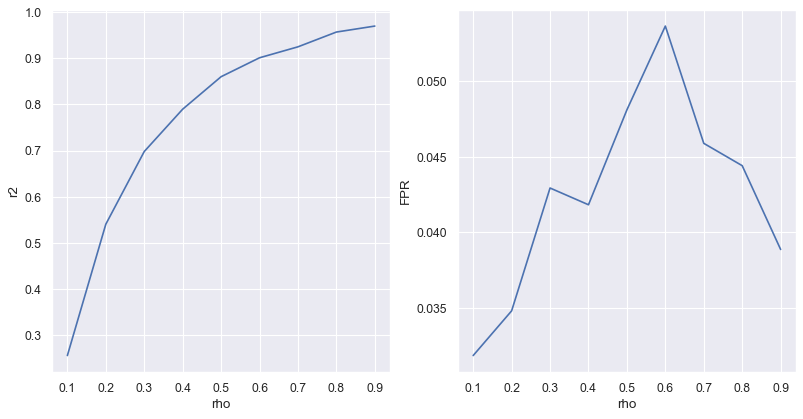

In [130]:
fig = plt.figure(figsize=(12, 6))
fig.add_subplot(121)
sns.lineplot(data=results_for_diag_corr, x='rho', y= 'r2')
fig.add_subplot(122)
sns.lineplot(data=results_for_diag_corr, x='rho', y= 'FPR')
plt.savefig('plots/diff_corr.pdf')
plt.show()


## Testing different correlation structures (not constant ones)

In [137]:
def run_model3(n_samples, m_genes, cov_mat, show_plot = False):
    np.random.seed(42)
    sigma_sq = 1
    # change to explore the effect of how corelated y is with the covariates.
    beta_val = np.random.choice([0, 2], (m_genes,), p= [0.9, 0.1])
    highly_corr = np.where(beta_val == 2)
    X, y = create_data3(n_samples, m_genes, cov_mat, sigma_sq, beta_val, plot=False)

    TEST_SIZE = 0.3
    y_scaled = scale(y)
    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=TEST_SIZE)
    # use CV to find optimum alpha


    alphas = np.linspace(0.0001, 0.5, num=10)
    
    # print('Doing grid search now')
    l_gs = GridSearchCV(
        make_pipeline(
            StandardScaler(),
            Lasso(tol=1e-1) 
            ),
            param_grid={'lasso__alpha': alphas}, 
            cv=KFold(5, shuffle=True, random_state=1234), 
            scoring="neg_root_mean_squared_error"
    ).fit(X_train, y_train)

    best_alpha = l_gs.best_params_['lasso__alpha']


    cv_res = pd.DataFrame(
        data = l_gs.cv_results_
    ).filter(
        regex = '(split[0-9]+|mean)_test_score'
    ).assign(
    # Add the alphas as a column 
        alpha = alphas
    )
    cv_res.update(
    # Convert negative rmses to positive
    -1 * cv_res.filter(regex = '_test_score')
    )
    
    if show_plot == True:
        sns.lineplot(x='alpha', y='mean_test_score', data=cv_res)
        plt.xlabel('$\lambda$')
        plt.ylabel('Negative RMSE')
        plt.show()

    m = Lasso(alpha=best_alpha, tol=1e-3).fit(X_train, y_train)
    r2, rmse =model_fit(m, X_test, y_test, plot=False)
    non_zero_coefs = np.where(m.coef_ != 0.)[0] #+ 1

    return rmse, r2, non_zero_coefs, highly_corr

In [37]:
n_samples = 500
m_genes = 3000

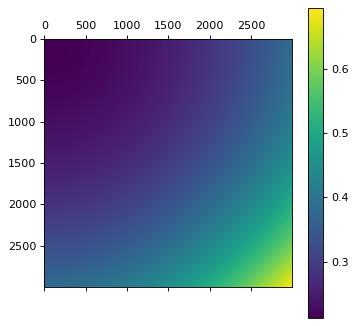

In [18]:
corr_1 = np.triu(np.linspace(0, 0.5, m_genes))
corr_1 = corr_1 + corr_1.T - np.diag(np.diag(corr_1))
corr_1 = nearestPD(corr_1)
plt.matshow(corr_1)
plt.colorbar()
plt.savefig('plots/mat1.pdf')
plt.show()

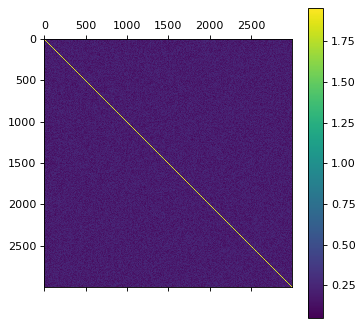

In [19]:
corr_2 = np.random.choice([0.1, 0.3], (m_genes, m_genes), p=[0.5, 0.5])
corr_2 = nearestPD(corr_2)
plt.matshow(corr_2)
plt.colorbar()
plt.savefig('plots/mat2.pdf')
plt.show()

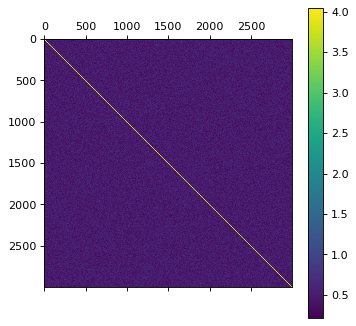

In [20]:
corr_3 = np.random.choice([0.3, 0.7], (m_genes, m_genes), p=[0.5, 0.5])
corr_3 = nearestPD(corr_3)
plt.matshow(corr_3)
plt.colorbar()
plt.savefig('plots/mat3.pdf')
plt.show()

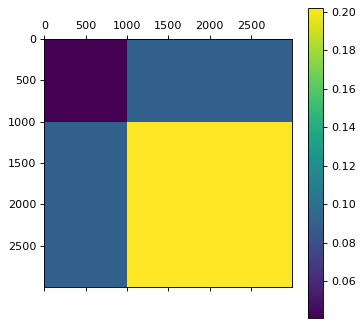

In [21]:
corr_4 = np.concatenate((np.full((m_genes,int(m_genes/3)), 0), np.full((m_genes,int(2*m_genes/3)), 0.2)), axis=1)
corr_4 = nearestPD(corr_4)
plt.matshow(corr_4)
plt.colorbar()
plt.savefig('plots/mat4.pdf')
plt.show()

In [86]:
corr_structures = [corr_1, corr_2, corr_3, corr_4]
my_results_cors = {'corr': ['INC', 'RLM', 'RMH', 'UEQ'], 'rmse': [], 'r2': [],'TP': [], 'FN': [], 'FP': [], 'TN': [], 'FPR': []}
for corr in corr_structures:
    rmse, r2, non_zero_coefs, highly_corr = run_model3(n_samples, m_genes, corr, show_plot =False)
    my_results_cors['rmse'].append(rmse)
    my_results_cors['r2'].append(r2)
    TP = len(np.intersect1d(highly_corr[0], non_zero_coefs))
    FN = len(np.setdiff1d(highly_corr[0], non_zero_coefs))
    FP = len(np.setdiff1d(non_zero_coefs, highly_corr[0]))
    TN = m_genes - TP - FN - FP
    FPR = FP / (FP + TN)
    my_results_cors['TP'].append(TP)
    my_results_cors['FN'].append(FN)
    my_results_cors['FP'].append(FP)
    my_results_cors['TN'].append(TN)
    my_results_cors['FPR'].append(FPR)

In [87]:
results_diff_corr = pd.DataFrame(my_results_cors)
results_diff_corr

,corr,rmse,r2,TP,FN,FP,TN,FPR
0,INC,0.007524,0.999934,295,3,2664,38,0.985936
1,RLM,0.690831,0.350426,51,247,108,2594,0.039970
2,RMH,0.672000,0.409165,47,251,144,2558,0.053294
3,UEQ,0.011912,0.999834,3,295,9,2693,0.003331


In [131]:
print(results_diff_corr.to_latex())

\begin{tabular}{llrrrrrrr}
\toprule
{} & corr &      rmse &        r2 &   TP &   FN &    FP &    TN &       FPR \\
\midrule
0 &  INC &  0.007524 &  0.999934 &  295 &    3 &  2664 &    38 &  0.985936 \\
1 &  RLM &  0.690831 &  0.350426 &   51 &  247 &   108 &  2594 &  0.039970 \\
2 &  RMH &  0.672000 &  0.409165 &   47 &  251 &   144 &  2558 &  0.053294 \\
3 &  UEQ &  0.011912 &  0.999834 &    3 &  295 &     9 &  2693 &  0.003331 \\
\bottomrule
\end{tabular}



## Testing different number of genes and samples

In [139]:
corr_str=0.3
diff_samples = [100, 300, 500, 700, 1000]
diff_genes = [100, 300, 1000, 3000, 5000]
my_results_cors = {'samples': [], 'genes': [], 'rmse': [], 'r2': [], 'TP': [], 'FN': [], 'FP': [], 'TN': [], 'FPR': []}
for i in diff_samples:
    for j in diff_genes:
        print('Testing: samples {}, genes {}'.format(i, j))
        rmse, r2, non_zero_coefs, highly_corr = run_model2(i, j, corr_str, show_plot =False)
        my_results_cors['samples'].append(i)
        my_results_cors['genes'].append(j)    
        my_results_cors['rmse'].append(rmse)
        my_results_cors['r2'].append(r2)
        TP = len(np.intersect1d(highly_corr[0], non_zero_coefs))
        FN = len(np.setdiff1d(highly_corr[0], non_zero_coefs))
        FP = len(np.setdiff1d(non_zero_coefs, highly_corr[0]))
        TN = m_genes - TP - FN - FP
        FPR = FP / (FP + TN)
        my_results_cors['TP'].append(TP)
        my_results_cors['FN'].append(FN)
        my_results_cors['FP'].append(FP)
        my_results_cors['TN'].append(TN)
        my_results_cors['FPR'].append(FPR)
        print('--'*30)

Testing: samples 100, genes 100
0.05564444444444445
------------------------------------------------------------
Testing: samples 100, genes 300
0.05564444444444445
------------------------------------------------------------
Testing: samples 100, genes 1000
0.05564444444444445
------------------------------------------------------------
Testing: samples 100, genes 3000
0.05564444444444445
------------------------------------------------------------
Testing: samples 100, genes 5000
0.05564444444444445
------------------------------------------------------------
Testing: samples 300, genes 100
0.05564444444444445
------------------------------------------------------------
Testing: samples 300, genes 300
0.05564444444444445
------------------------------------------------------------
Testing: samples 300, genes 1000
0.05564444444444445
------------------------------------------------------------
Testing: samples 300, genes 3000
0.05564444444444445
---------------------------------------

In [89]:
full_results = pd.DataFrame(my_results_cors)

In [91]:
full_results

,samples,genes,rmse,r2,TP,FN,FP,TN,FPR
0,100,100,0.365593,0.836938,9,0,5,2986,0.001672
1,100,300,0.617621,0.521356,12,17,30,2941,0.010098
2,100,1000,0.781530,0.567492,9,91,32,2868,0.011034
3,100,3000,0.690153,0.369644,7,291,41,2661,0.015174
4,100,5000,0.713403,0.503539,3,476,39,2482,0.015470
5,300,100,0.340254,0.900408,9,0,1,2990,0.000334
6,300,300,0.281159,0.864777,29,0,17,2954,0.005722
7,300,1000,0.512716,0.701999,25,75,69,2831,0.023793
8,300,3000,0.694346,0.608026,17,281,96,2606,0.035529
9,300,5000,0.497752,0.726444,15,464,83,2438,0.032923


In [132]:
print(full_results.to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  samples &  genes &      rmse &        r2 &  TP &   FN &   FP &    TN &       FPR \\
\midrule
0  &      100 &    100 &  0.365593 &  0.836938 &   9 &    0 &    5 &  2986 &  0.001672 \\
1  &      100 &    300 &  0.617621 &  0.521356 &  12 &   17 &   30 &  2941 &  0.010098 \\
2  &      100 &   1000 &  0.781530 &  0.567492 &   9 &   91 &   32 &  2868 &  0.011034 \\
3  &      100 &   3000 &  0.690153 &  0.369644 &   7 &  291 &   41 &  2661 &  0.015174 \\
4  &      100 &   5000 &  0.713403 &  0.503539 &   3 &  476 &   39 &  2482 &  0.015470 \\
5  &      300 &    100 &  0.340254 &  0.900408 &   9 &    0 &    1 &  2990 &  0.000334 \\
6  &      300 &    300 &  0.281159 &  0.864777 &  29 &    0 &   17 &  2954 &  0.005722 \\
7  &      300 &   1000 &  0.512716 &  0.701999 &  25 &   75 &   69 &  2831 &  0.023793 \\
8  &      300 &   3000 &  0.694346 &  0.608026 &  17 &  281 &   96 &  2606 &  0.035529 \\
9  &      300 &   5000 &  0.497752 &  0.726444 &  15 &

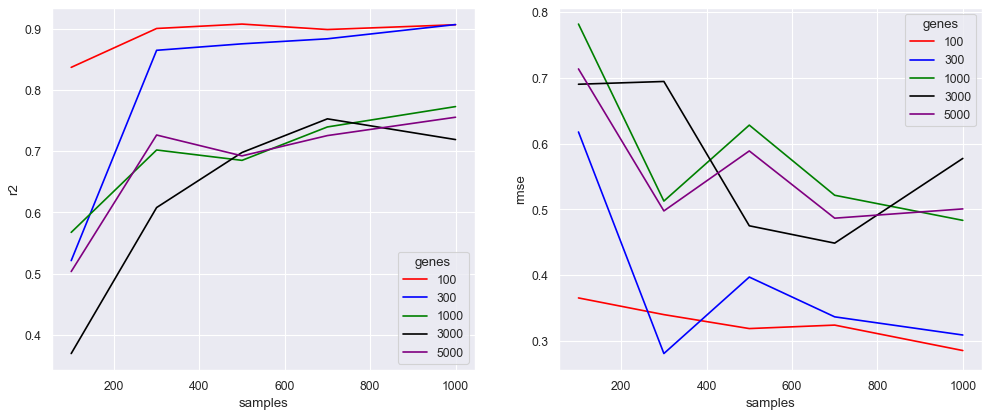

In [151]:
fig = plt.figure(figsize=(15, 6))
fig.add_subplot(121)
pal = ['red', 'blue', 'green', 'black', 'purple']
sns.lineplot(x='samples', y='r2', hue='genes', data=full_results, palette=pal)
fig.add_subplot(122)
sns.lineplot(x='samples', y='rmse', hue='genes', data=full_results,  palette=pal)
plt.savefig('plots/last.pdf')
plt.show()

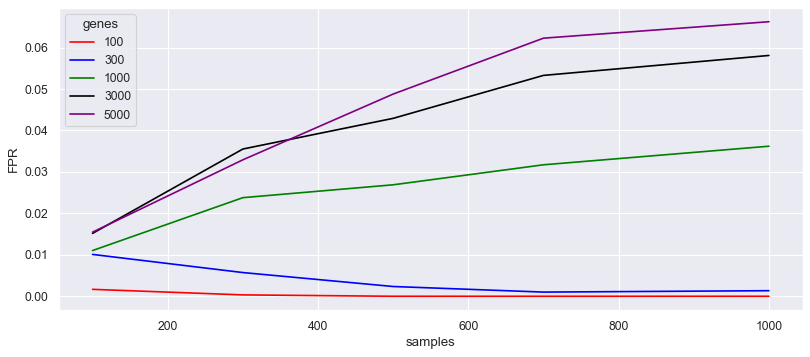

In [152]:
g = sns.lineplot(x='samples', y='FPR', hue='genes', data=full_results, palette=pal)
plt.savefig('plots/last2.pdf')
plt.show()